# Reference envelop plots

Plots profiles reference envelop unsing PCM selection or not (as in Maze et al, 2017)

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import argopy
argopy.set_options(src='localftp', local_ftp='/home/coriolis_exp/spool/co05/co0508/')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

import scipy as sp
from scipy.io import loadmat
from scipy import interpolate

import seawater as sw

from classif_functions import *

In [2]:
def get_dataow(file_path):
    
    # load from .met file
    mat_dict_load = sp.io.loadmat(file_path)
    
    #create a xarray dataset
    ds_ref = xr.Dataset(
         data_vars=dict(
             pres=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_pres']),
             ptmp=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_ptmp']),
             sal=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_sal']),
         ),
         coords=dict(
             long=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_long'])),
             lat=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_lat'])),
             dates=(["n_profiles"], pd.to_datetime(list(map(str, map(int, np.squeeze(mat_dict_load['la_bhist_dates'])))))),
         ),
     )

    return ds_ref

__Input__

In [3]:
float_WMO = 4900136
prof_num = 78

## 1. Load float profile

using argopy

In [4]:
argo_loader = ArgoDataFetcher()
    
ds_f = argo_loader.profile(float_WMO, prof_num).to_xarray()
ds_f = ds_f.argo.point2profile()

In [5]:
ds_f

<xarray.Dataset>
Dimensions:                (N_LEVELS: 71, N_PROF: 1)
Coordinates:
  * N_PROF                 (N_PROF) int64 0
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 5 6 ... 65 66 67 68 69 70
    LONGITUDE              (N_PROF) float64 -61.63
    LATITUDE               (N_PROF) float64 40.38
    TIME                   (N_PROF) datetime64[ns] 2004-08-14T07:39:00
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int64 0
    CYCLE_NUMBER           (N_PROF) int64 78
    DATA_MODE              (N_PROF) <U1 'D'
    DIRECTION              (N_PROF) <U1 'A'
    PLATFORM_NUMBER        (N_PROF) int64 4900136
    POSITION_QC            (N_PROF) int64 1
    PRES                   (N_PROF, N_LEVELS) float64 8.8 9.4 ... 1.999e+03
    PRES_QC                (N_PROF) int64 1
    PSAL                   (N_PROF, N_LEVELS) float64 35.77 35.77 ... 34.92
    PSAL_QC                (N_PROF) int64 1
    TEMP                   (N_PROF, N_LEVELS) float64 25.7 25.7 ... 3.546 3.481
    TEMP_QC                (N_PROF) int64 1
    TIME_QC                (N_PROF) int64 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/08/23
    Fetched_constraints:  phy;WMO4900136_CYC78
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/meds/4900...
    history:              Variables filtered according to DATA_MODE; Variable...

In [6]:
pr = 0 # reference pressure in dbar
ds_f = ds_f.assign(ptmp=(["N_PROF", "N_LEVELS"], sw.ptmp(ds_f['PSAL'].values,ds_f['TEMP'].values,ds_f['PRES'].values,pr)))

In [7]:
ds_f

<xarray.Dataset>
Dimensions:                (N_LEVELS: 71, N_PROF: 1)
Coordinates:
  * N_PROF                 (N_PROF) int64 0
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 5 6 ... 65 66 67 68 69 70
    LONGITUDE              (N_PROF) float64 -61.63
    LATITUDE               (N_PROF) float64 40.38
    TIME                   (N_PROF) datetime64[ns] 2004-08-14T07:39:00
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int64 0
    CYCLE_NUMBER           (N_PROF) int64 78
    DATA_MODE              (N_PROF) <U1 'D'
    DIRECTION              (N_PROF) <U1 'A'
    PLATFORM_NUMBER        (N_PROF) int64 4900136
    POSITION_QC            (N_PROF) int64 1
    PRES                   (N_PROF, N_LEVELS) float64 8.8 9.4 ... 1.999e+03
    PRES_QC                (N_PROF) int64 1
    PSAL                   (N_PROF, N_LEVELS) float64 35.77 35.77 ... 34.92
    PSAL_QC                (N_PROF) int64 1
    TEMP                   (N_PROF, N_LEVELS) float64 25.7 25.7 ... 3.546 3.481
    TEMP_QC                (N_PROF) int64 1
    TIME_QC                (N_PROF) int64 1
    ptmp                   (N_PROF, N_LEVELS) float64 25.7 25.7 ... 3.39 3.321
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/08/23
    Fetched_constraints:  phy;WMO4900136_CYC78
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/meds/4900...
    history:              Variables filtered according to DATA_MODE; Variable...

In [8]:
ds_f.PRES.max().values

array(1999.30004883)

## 2. Load reference data

__data without class selection__

In [9]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata.mat'
ds_ref = get_dataow(file_path)
ds_ref

<xarray.Dataset>
Dimensions:  (n_pres: 1033, n_profiles: 250)
Coordinates:
    long     (n_profiles) float64 298.8 298.6 299.6 298.9 ... 302.3 301.4 301.3
    lat      (n_profiles) float64 40.08 40.92 40.67 40.65 ... 38.55 36.63 37.1
    dates    (n_profiles) datetime64[ns] 2007-01-01 2007-01-01 ... 2016-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 4.5 4.9 4.7 3.1 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 18.62 17.23 21.03 ... nan nan nan
    sal      (n_pres, n_profiles) float64 35.72 35.54 36.48 ... nan nan nan

interpolation to standard levels

In [10]:
max_depth = 1000
std_lev = np.arange(0,max_depth)
ds_refi = interpolate_standard_levels(ds_ref, std_lev)
ds_refi

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 234)
Coordinates:
    dates              (n_profiles) datetime64[ns] 2007-01-01 ... 2016-01-01
    long               (n_profiles) float64 298.6 296.5 298.5 ... 301.4 301.3
    lat                (n_profiles) float64 40.92 40.47 41.21 ... 36.63 37.1
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 996 997 998 999
Dimensions without coordinates: n_profiles
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 4.9 4.9 ... 999.0
    ptmp               (n_profiles, PRES_INTERPOLATED) float64 17.23 ... 8.526
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.54 ... 35.14

__data with class selection__

In [11]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_class.mat'
ds_ref_class = get_dataow(file_path)
ds_ref_class

<xarray.Dataset>
Dimensions:  (n_pres: 1033, n_profiles: 250)
Coordinates:
    long     (n_profiles) float64 299.2 296.8 296.3 295.3 ... 303.3 304.9 301.3
    lat      (n_profiles) float64 40.49 40.38 40.04 40.37 ... 39.79 39.57 39.2
    dates    (n_profiles) datetime64[ns] 2013-01-01 2005-01-01 ... 2013-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 1.0 10.0 10.0 5.0 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 23.43 24.46 23.24 28.0 ... nan nan nan
    sal      (n_pres, n_profiles) float64 35.65 35.3 36.46 36.16 ... nan nan nan

interpolation to standard levels

In [12]:
max_depth = 1000
std_lev = np.arange(0,max_depth)
ds_ref_classi = interpolate_standard_levels(ds_ref_class, std_lev)
ds_ref_classi

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 250)
Coordinates:
    dates              (n_profiles) datetime64[ns] 2013-01-01 ... 2013-01-01
    long               (n_profiles) float64 299.2 296.8 296.3 ... 304.9 301.3
    lat                (n_profiles) float64 40.49 40.38 40.04 ... 39.57 39.2
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 996 997 998 999
Dimensions without coordinates: n_profiles
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 1.0 1.0 ... 999.0
    ptmp               (n_profiles, PRES_INTERPOLATED) float64 23.43 ... 4.985
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.65 ... 35.01

Calculate mean and std

In [13]:
mean_ptmp = np.nanmean(ds_refi['ptmp'], axis=0)
std_ptmp = np.nanstd(ds_refi['ptmp'], axis=0)
mean_sal = np.nanmean(ds_refi['sal'], axis=0)
std_sal = np.nanstd(ds_refi['sal'], axis=0)

mean_ptmp_class = np.nanmean(ds_ref_classi['ptmp'], axis=0)
std_ptmp_class = np.nanstd(ds_ref_classi['ptmp'], axis=0)
mean_sal_class = np.nanmean(ds_ref_classi['sal'], axis=0)
std_sal_class = np.nanstd(ds_ref_classi['sal'], axis=0)

## 3. Plots

__Potential temperature__

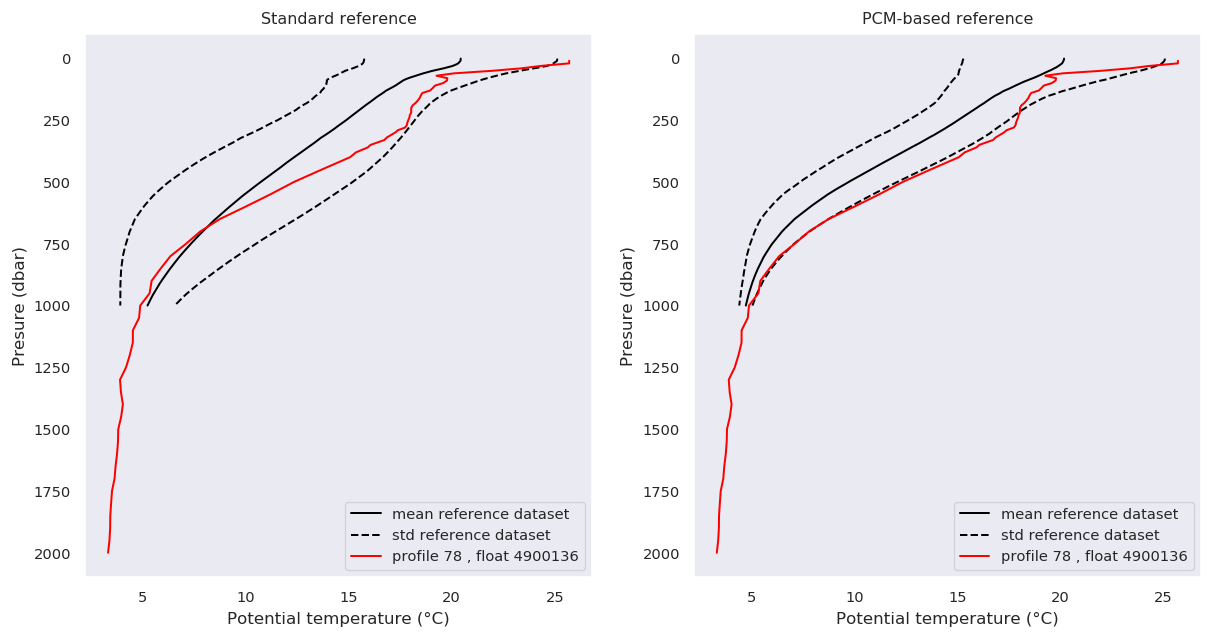

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

ax[0].plot(mean_ptmp, ds_refi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[0].plot(mean_ptmp + std_ptmp, ds_refi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset');
ax[0].plot(mean_ptmp - std_ptmp, ds_refi['PRES_INTERPOLATED'].values, 'k--');
ax[0].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[0].set_title('Standard reference')
ax[0].legend()

ax[1].plot(mean_ptmp_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[1].plot(mean_ptmp_class + std_ptmp_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset');
ax[1].plot(mean_ptmp_class - std_ptmp_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--');
ax[1].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[1].set_title('PCM-based reference')
ax[1].legend()

__Salinity__

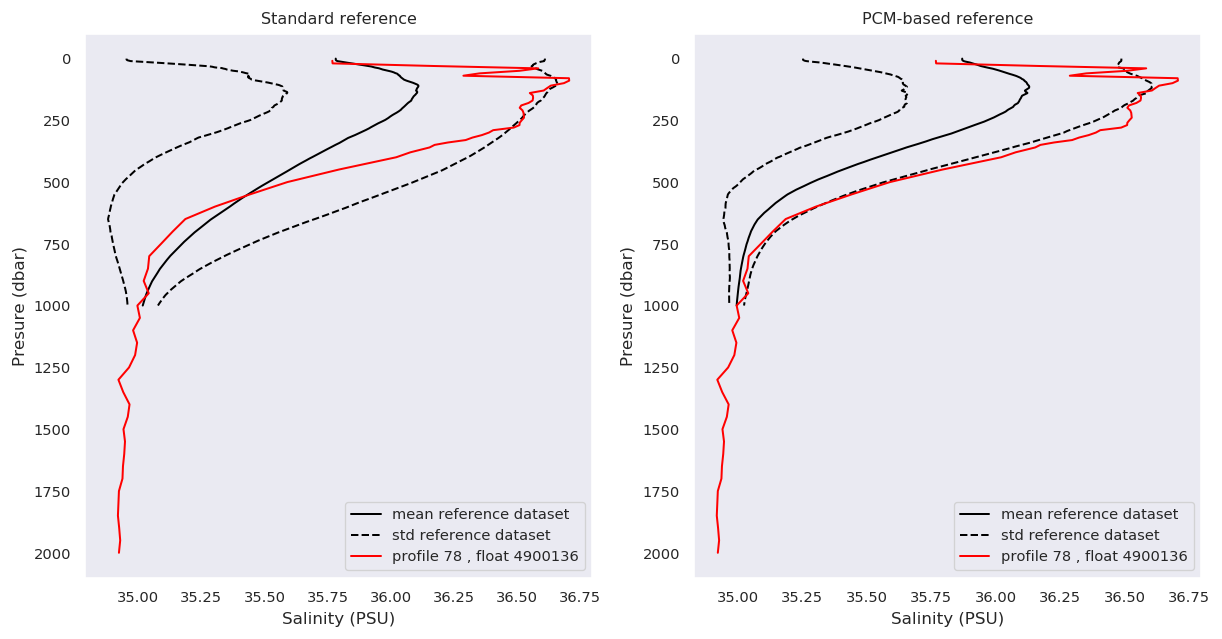

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

ax[0].plot(mean_sal, ds_refi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[0].plot(mean_sal + std_sal, ds_refi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset')
ax[0].plot(mean_sal - std_sal, ds_refi['PRES_INTERPOLATED'].values, 'k--')
ax[0].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Salinity (PSU)', fontsize=10);
ax[0].set_title('Standard reference')
ax[0].legend()

ax[1].plot(mean_sal_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k', label='mean reference dataset');
ax[1].plot(mean_sal_class + std_sal_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--', label='std reference dataset');
ax[1].plot(mean_sal_class - std_sal_class, ds_ref_classi['PRES_INTERPOLATED'].values, 'k--');
ax[1].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Salinity (PSU)', fontsize=10);
ax[1].set_title('PCM-based reference')
ax[1].legend()

Print all profiles

Text(0.5, 1.0, 'PCM-based reference')

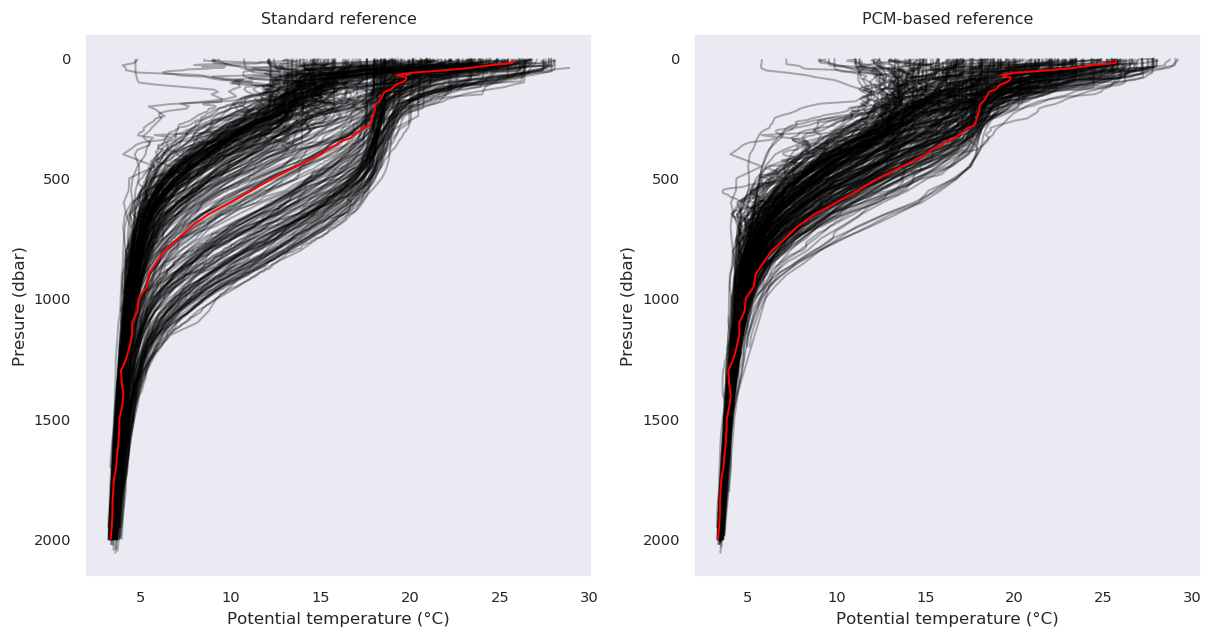

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['ptmp'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[0].set_title('Standard reference')
#ax[0].legend()

for i in range(len(ds_ref_class['n_profiles'])):
    ax[1].plot(ds_ref_class['ptmp'].isel(n_profiles = i), ds_ref_class['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[1].set_title('PCM-based reference')
#ax[1].legend()

Text(0.5, 1.0, 'PCM-based reference')

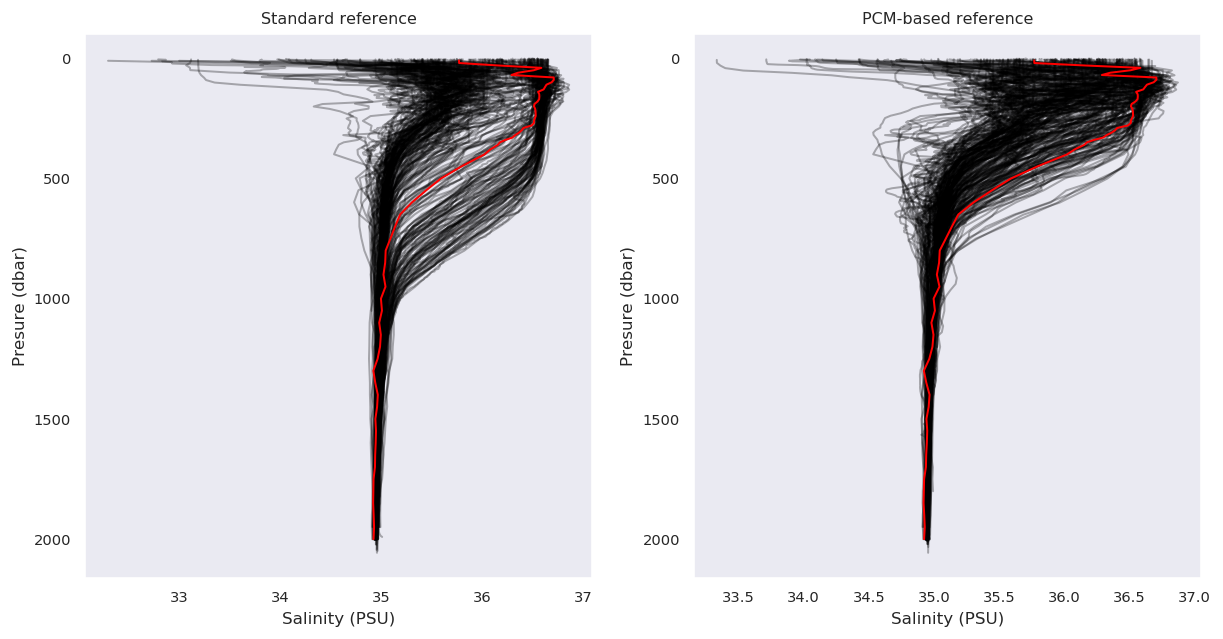

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['sal'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Salinity (PSU)', fontsize=10);
ax[0].set_title('Standard reference')
#ax[0].legend()

for i in range(len(ds_ref_class['n_profiles'])):
    ax[1].plot(ds_ref_class['sal'].isel(n_profiles = i), ds_ref_class['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Salinity (PSU)', fontsize=10);
ax[1].set_title('PCM-based reference')
#ax[1].legend()

Plot ellipses with and without class selection

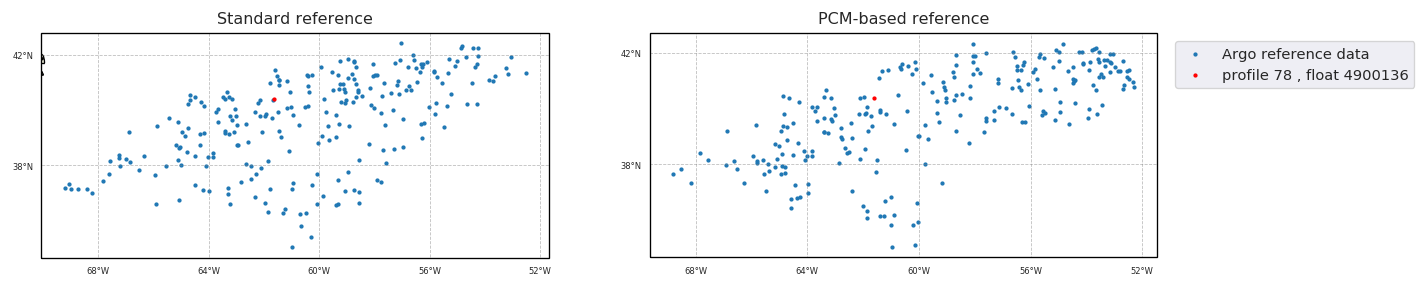

In [18]:
#selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

# without class selection
p1 = ax[0].scatter(ds_ref['long'], ds_ref['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[0].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[0].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[0].gridlines(crs=ax[0].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
ax[0].set_title('Standard reference')

# with class selection
p1 = ax[1].scatter(ds_ref_class['long'], ds_ref_class['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[1].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[1].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[1].gridlines(crs=ax[1].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
ax[1].set_title('PCM-based reference')

ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')